### Load necessary libraries

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import pickle
from tqdm import tqdm_notebook
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE

### Load current state of object

In [3]:
#Functions to save objects for later use and retireve it
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".pkl","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".pkl","rb"))
    return temp


y_train =openfromfile('y_train')
y_test =openfromfile('y_test')

count_vect =openfromfile('count_vect')
X_train_bigram = openfromfile('X_train_bigram')
X_test_bigram = openfromfile('X_test_bigram')

tf_idf_vect =openfromfile('tf_idf_vect')
X_train_tfidf =openfromfile('X_train_tfidf')
X_test_tfidf =openfromfile('X_test_tfidf')

avg_sent_vectors=openfromfile('avg_sent_vectors')
avg_sent_vectors_test=openfromfile('avg_sent_vectors_test')

tfidf_sent_vectors=openfromfile('tfidf_sent_vectors')
tfidf_sent_vectors_test=openfromfile('tfidf_sent_vectors_test')

y_train_kd =openfromfile('y_train_kd')
y_test_kd =openfromfile('y_test_kd')

count_vect_kd =openfromfile('count_vect_kd')
X_train_bigram_kd=openfromfile('X_train_bigram_kd')
X_test_bigram_kd=openfromfile('X_test_bigram_kd')

tf_idf_vect_kd =openfromfile('tf_idf_vect_kd')
X_train_tfidf_kd=openfromfile('X_train_tfidf_kd')
X_test_tfidf_kd=openfromfile('X_test_tfidf_kd')

avg_sent_vectors_kd=openfromfile('avg_sent_vectors_kd')
avg_sent_vectors_test_kd=openfromfile('avg_sent_vectors_test_kd')

#tfidf_sent_vectors_rbf
tfidf_sent_vectors_kd=openfromfile('tfidf_sent_vectors_kd')
tfidf_sent_vectors_test_kd=openfromfile('tfidf_sent_vectors_test_kd')

In [6]:
print('shape of train data used for brute force KNN model: ',X_train_bigram.shape)
print('shape of test data used for brute force KNN model: ',X_test_bigram.shape)

print('shape of train data used for kd-tree KNN model: ',X_train_bigram_kd.shape)
print('shape of test data used for kd-tree KNN model: ',X_test_bigram_kd.shape)

shape of train data used for brute force KNN model:  (49000, 30357)
shape of test data used for brute force KNN model:  (21000, 30357)
shape of train data used for kd-tree KNN model:  (14000, 500)
shape of test data used for kd-tree KNN model:  (6000, 500)


### Save and Load Model:

In [8]:
def saveModeltofile(obj,filename):
    joblib.dump(obj,open(filename+".pkl","wb"))
def openModelfromfile(filename):
    temp = joblib.load(open(filename+".pkl","rb"))
    return temp

### Standardizing data

In [9]:
def std_data(train,test,mean):
    scaler=StandardScaler(with_mean=mean)
    std_train=scaler.fit_transform(train)
    std_test=scaler.transform(test)
    return std_train, std_test

# KNN

### Function for finding optimal value of hyperparameter nd plot missclassification error vs k :

In [10]:
def KNN_Classifier(x_train,y_train,TBS,params,searchMethod,algo,vect):
    ''' FUNCTION FOR FINDING OPTIMAL VALUE OF HYPERPARAM AND DRAW ERROR PLOT'''   
    #INITIALIZE KNN OBJECT
    clf=KNeighborsClassifier(algorithm=algo)
    
    # APPLY RANDOM OR GRID SEARCH FOR HYPERPARAMETER TUNNING
    if searchMethod=='grid':
        model=GridSearchCV(clf,\
                           n_jobs=16,\
                           cv=TBS,\
                           param_grid=params,\
                           return_train_score=True,\
                           scoring=make_scorer(roc_auc_score))
    elif searchMethod=='random':
        model=RandomizedSearchCV(clf,\
                                 n_jobs=16,\
                                 cv=TBS,\
                                 param_distributions=params,\
                                 n_iter=len(params['n_neighbors']),\
                                 return_train_score=True,\
                                 scoring=make_scorer(roc_auc_score))
    model.fit(x_train,y_train)
    
    #PLOT HYPERPARAM VS AUC VALUES(FOR BOTH CV AND TRAIN)     
    train_auc= model.cv_results_['mean_train_score']
    train_auc_std= model.cv_results_['std_train_score']
    cv_auc = model.cv_results_['mean_test_score'] 
    cv_auc_std= model.cv_results_['std_test_score']
    
    plt.figure(1,figsize=(10,6))
    sns.set_style('darkgrid')
    plt.plot(params['n_neighbors'], train_auc, label='Train AUC')
    # Reference Link: https://stackoverflow.com/a/48803361/4084039
    # gca(): get current axis
    plt.gca().fill_between(params['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    plt.plot(params['n_neighbors'], cv_auc, label='CV AUC')
    # Reference Link: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(params['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    
    plt.title('ERROR PLOT (%s Implementation for %s)' %(algo,vect))
    plt.xlabel('K: Hyperparam')
    plt.ylabel('AUC')
    plt.grid(True)
    plt.legend()
    plt.show()
    return model
        

### Function which calculate performance on test data with optimal K : 

In [11]:
def test_performance(x_train,y_train,x_test,y_test,optimal_k,algo,vect,summarize):
    '''FUNCTION FOR TEST PERFORMANCE(PLOT ROC CURVE FOR BOTH TRAIN AND TEST) WITH OPTIMAL_K'''
    clf=KNeighborsClassifier(algorithm=algo,n_neighbors=optimal_k,n_jobs=-1)
    clf.fit(x_train,y_train)
    data_used=['Test-Data','Train-Data']
    
    test_probability = clf.predict_proba(x_test)[:,1]
    train_probability = clf.predict_proba(x_train)[:,1]
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, test_probability)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, train_probability)
    auc_score_test=auc(fpr_test, tpr_test)
    auc_score_train=auc(fpr_train, tpr_train)
    y_pred={} ; y_act={};
    y_pred[data_used[0]]=clf.predict(x_test)
    y_pred[data_used[1]]=clf.predict(x_train)
    y_act[data_used[0]]=y_test
    y_act[data_used[1]]=y_train
    saveModeltofile(auc_score_train,'auc_score_train'+algo+vect)
    saveModeltofile(auc_score_test,'auc_score_test'+algo+vect)
    
    f1=f1_score(y_test,y_pred[data_used[0]],average='weighted')
    
    #ADD RESULTS TO PRETTY TABLE
    summarize.add_row([vect, algo, optimal_k, '%.3f'%auc_score_train, '%.3f'%auc_score_test, '%.3f'%f1])
    
    plt.figure(1,figsize=(14,5))
    sns.set_style('darkgrid')
    #plt.subplot(121)
    plt.title('ROC Curve (%s)' %vect)
    #IDEAL ROC CURVE
    plt.plot([0,1],[0,1],'k--')
    #ROC CURVE OF TEST DATA
    plt.plot(fpr_test, tpr_test , 'b', label='Test_AUC= %.2f' %auc_score_test)
    #ROC CURVE OF TRAIN DATA
    plt.plot(fpr_train, tpr_train , 'g', label='Train_AUC= %.2f' %auc_score_train)
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(loc='lower right')
    #PLOT CONFUSION MATRIX USING HEATMAP
    plt.figure(2,figsize=(16,6))
    sns.set_style('darkgrid')
    for k in range(2):
        #PLOT CONFUSION MATRIX USING HEATMAP
        plt.subplot(int('12'+str(k+1)))
        plt.title('Confusion-Matrix (%s)' %data_used[k])
        df_cm = pd.DataFrame(confusion_matrix(y_act[data_used[k]],y_pred[data_used[k]]),\
                             ['Negative','Positive'],['Negative','Positive'])
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm,cmap='gist_earth', annot=True,annot_kws={"size": 16}, fmt='g')
    plt.show()

### Initialization of common objects required for all vectorization:

In [12]:
#ALGO USED
algo=['brute','kd_tree']
#VECTORIZER
vect=['BoW','TF-IDF','AVG-W2V','TFIDF-W2V']
#OBJECT FOR TIMESERIES CROSS VALIDATION
TBS=TimeSeriesSplit(n_splits=10)
#METHOD USE FOR HYPER PARAMETER TUNNING
searchMethod='grid'
#RANGE OF K VALUES(HYPERPARAM)
k={'n_neighbors':[x for x in range(3,30,2)]}
#INITIALIZE PRETTY TABLE OBJECT
summarize = PrettyTable()
summarize.field_names = ['Vectorizer', 'Algorithm', 'Optimal-K', 'Train(AUC)', 'Test(AUC)','Test(F1-Score)']

### Apply KNN for BoW vectorizer

#### 1. Brute force implementation

shape of oversampled data y_train: (49000,) X_train: (49000, 30357)


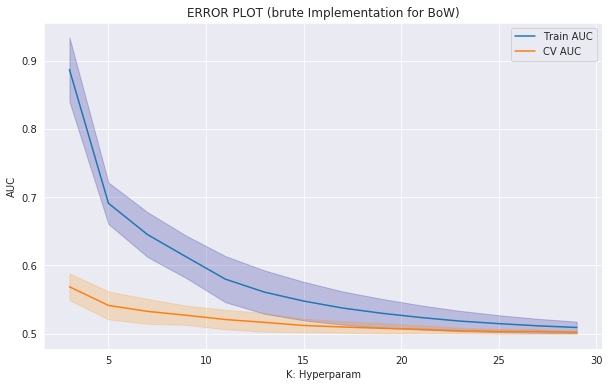

CPU times: user 1.55 s, sys: 2.04 s, total: 3.6 s
Wall time: 8min 29s
Optimal value of K:  {'n_neighbors': 3}


In [12]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_bigram,test=X_test_bigram,mean=False)
#train, y_train= sm.fit_sample(train, y_train)
print('shape of oversampled data y_train:',y_train.shape,'X_train:',train.shape)
#HYPERPARAM TUNNING
%time model=KNN_Classifier(train,y_train,TBS,k,searchMethod,algo[0],vect[0])
print('Optimal value of K: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_bow_knn')

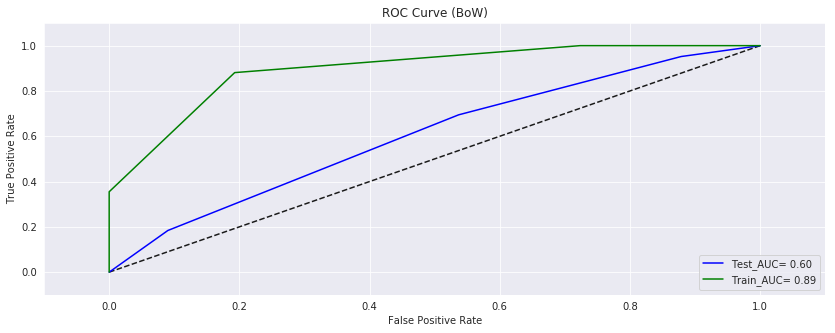

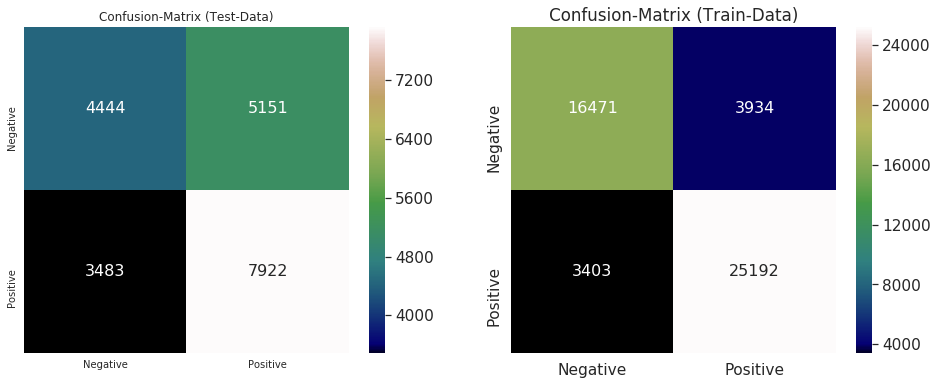

In [13]:
test_performance(train,y_train,test,y_test,model.best_params_['n_neighbors'],algo[0],vect[0],summarize)

#### 2. kd-tree implementation

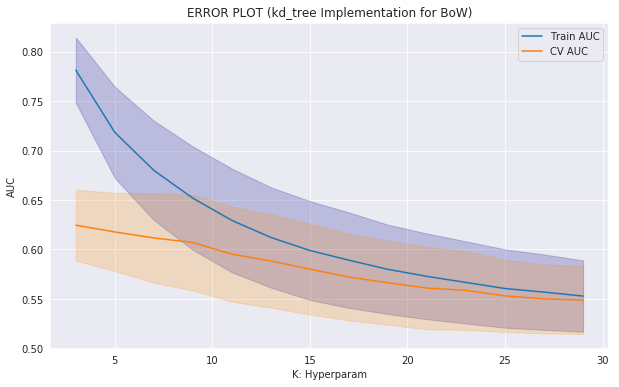

CPU times: user 2.99 s, sys: 2.11 s, total: 5.1 s
Wall time: 14min 52s
Optimal value of K:  {'n_neighbors': 3}


In [12]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_bigram_kd,test=X_test_bigram_kd,mean=False)
train_dense,test_dense=train.toarray(), test.toarray()
#HYPERPARAM TUNNING
%time model=KNN_Classifier(train_dense,y_train_kd,TBS,k,searchMethod,algo[1],vect[0])
print('Optimal value of K: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_bow_kd_knn')

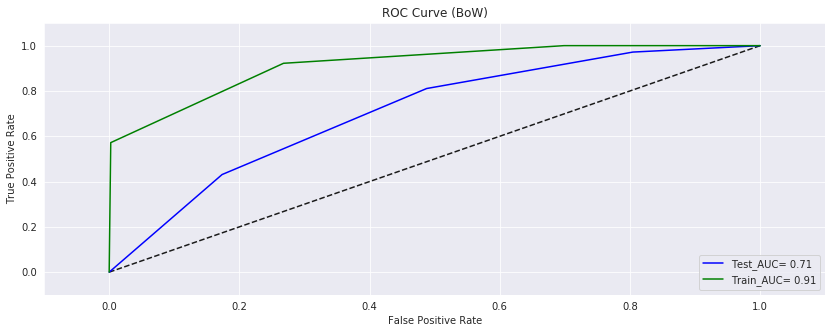

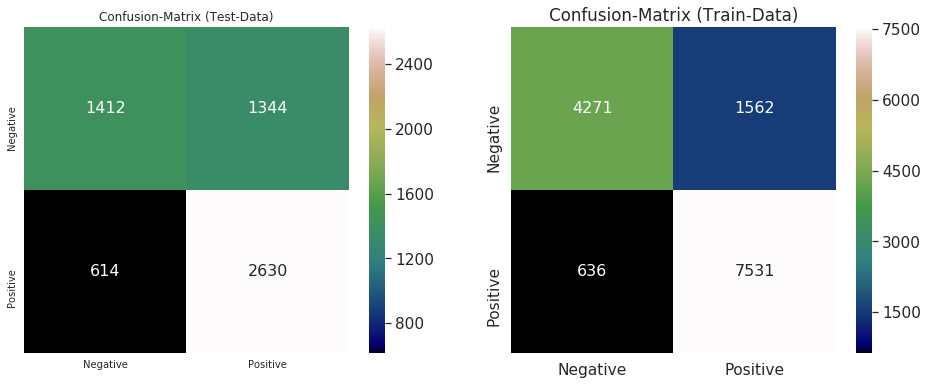

In [13]:
test_performance(train_dense,y_train_kd,test_dense,y_test_kd,model.best_params_['n_neighbors'],algo[1],vect[0],summarize)

### Apply KNN for TF-IDF vectorizer

#### 1. Brute force implementation

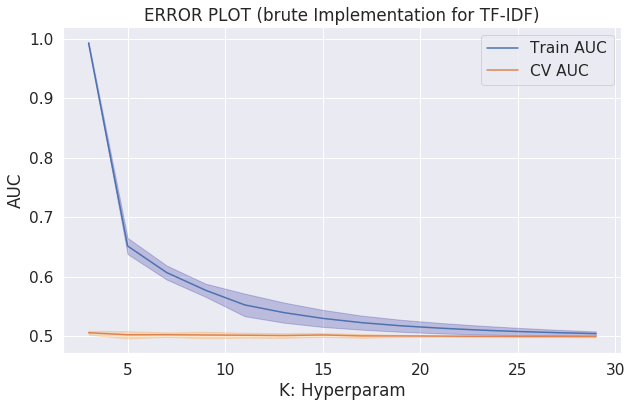

CPU times: user 1.17 s, sys: 820 ms, total: 1.99 s
Wall time: 9min 47s
Optimal value of K:  {'n_neighbors': 3}


In [15]:
#X_train, y_train =sm.fit_sample(X_train, y_train)
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_tfidf,test=X_test_tfidf,mean=False)
#OVERSAMPLE TRAIN DATA 
#train, y_train =sm.fit_sample(train, y_train)
#HYPERPARAM TUNNING
%time model=KNN_Classifier(train,y_train,TBS,k,searchMethod,algo[0],vect[1])
print('Optimal value of K: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidf_knn')

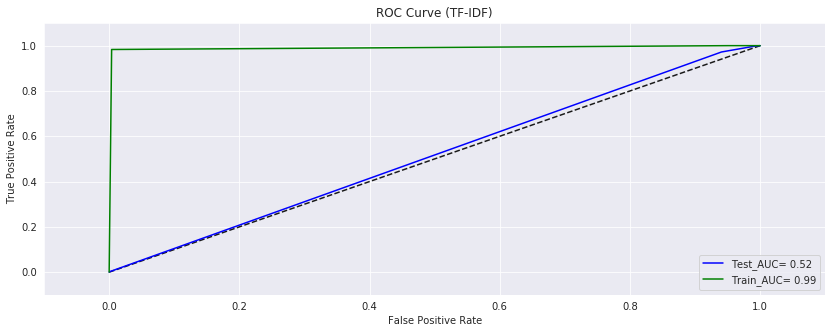

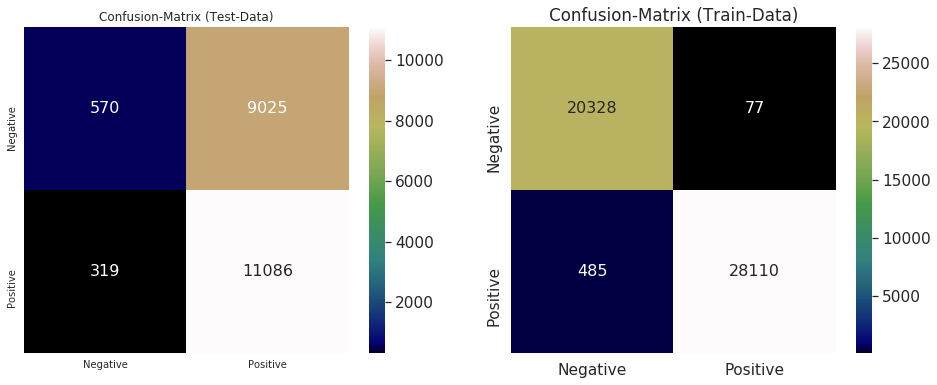

In [15]:
test_performance(train,y_train,test,y_test,model.best_params_['n_neighbors'],algo[0],vect[1],summarize)

#### 2. kd-tree implementation

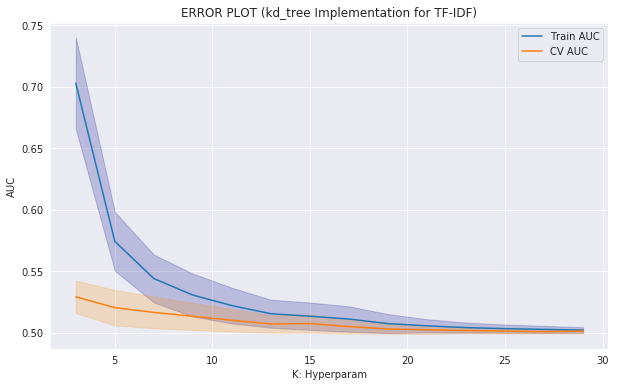

CPU times: user 2.56 s, sys: 1.18 s, total: 3.74 s
Wall time: 14min 55s
Optimal value of K:  {'n_neighbors': 3}


In [15]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_tfidf_kd,test=X_test_tfidf_kd,mean=False)
train_dense,test_dense=train.toarray(), test.toarray()
#HYPERPARAM TUNNING
%time model=KNN_Classifier(train_dense,y_train_kd,TBS,k,searchMethod,algo[1],vect[1])
print('Optimal value of K: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidf_kd_knn')

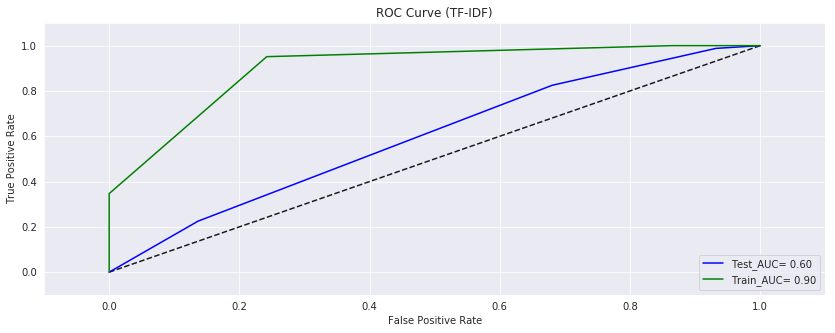

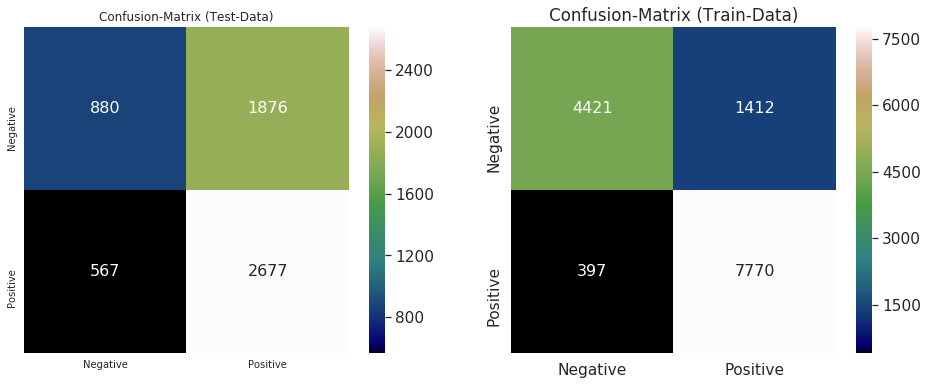

In [16]:
test_performance(train_dense,y_train_kd,test_dense,y_test_kd,model.best_params_['n_neighbors'],algo[1],vect[1],summarize)

### Apply KNN for AVG-W2V vectorizer

#### 1. Brute force implementation

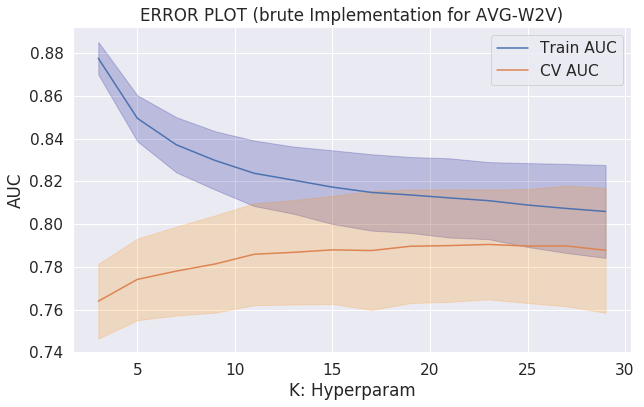

CPU times: user 1.54 s, sys: 1.7 s, total: 3.24 s
Wall time: 6min 14s
Optimal value of K:  {'n_neighbors': 23}


In [23]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=avg_sent_vectors,test=avg_sent_vectors_test,mean=True)
#OVERSAMPLE TRAIN DATA 
#train, y_train = oversampling(train, y_train)
#HYPERPARAM TUNNING
%time model=KNN_Classifier(train,y_train,TBS,k,searchMethod,algo[0],vect[2])
print('Optimal value of K: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_avgw2v_knn')

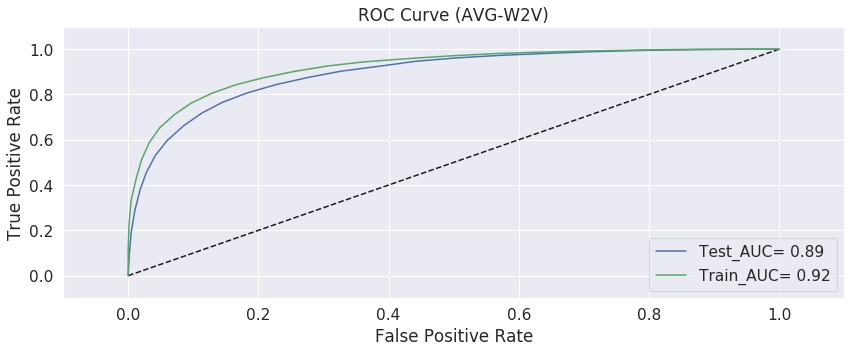

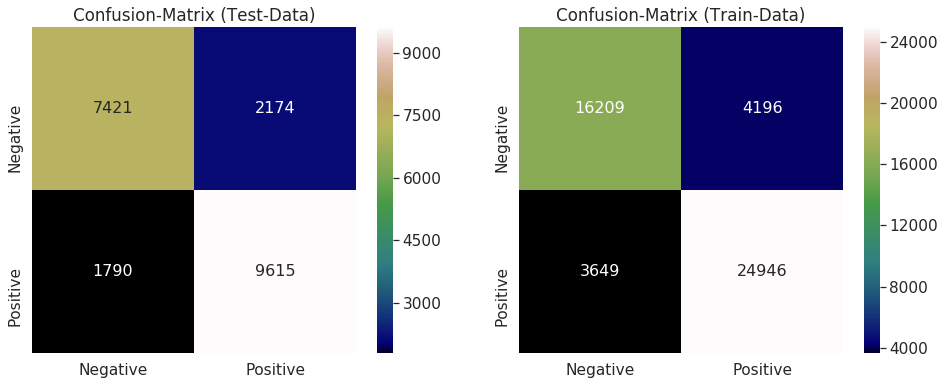

In [15]:
test_performance(train,y_train,test,y_test,model.best_params_['n_neighbors'],algo[0],vect[2],summarize)

#### 2. kd-tree implementation

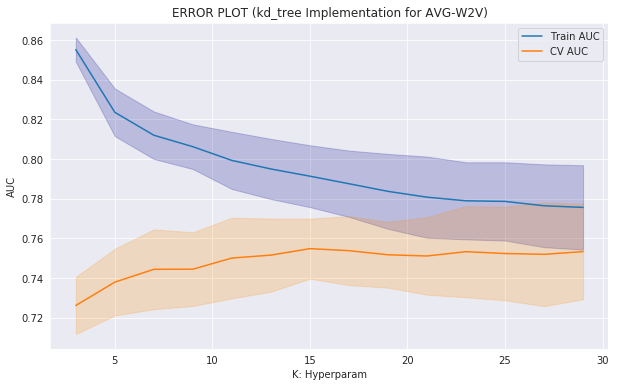

CPU times: user 1.37 s, sys: 1.73 s, total: 3.1 s
Wall time: 5min 20s
Optimal value of K:  {'n_neighbors': 15}


In [11]:
train, test=std_data(train=avg_sent_vectors_kd,test=avg_sent_vectors_test_kd,mean=True)
#HYPERPARAM TUNNING
%time model=KNN_Classifier(train,y_train_kd,TBS,k,searchMethod,algo[1],vect[2])
print('Optimal value of K: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_avgw2v_kd_knn')

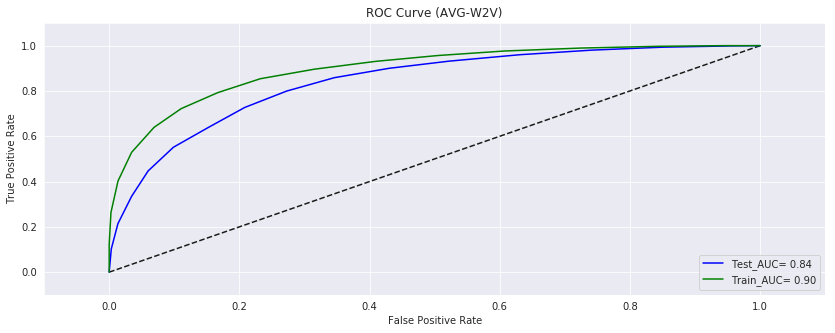

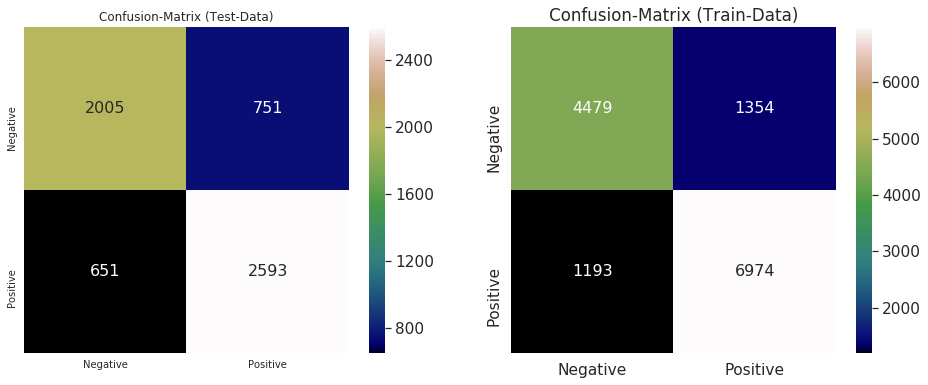

In [12]:
test_performance(train,y_train_kd,test,y_test_kd,model.best_params_['n_neighbors'],algo[1],vect[2],summarize)

### Apply KNN for TFIDF-W2V vectorizer

#### 1.Brute force implementation

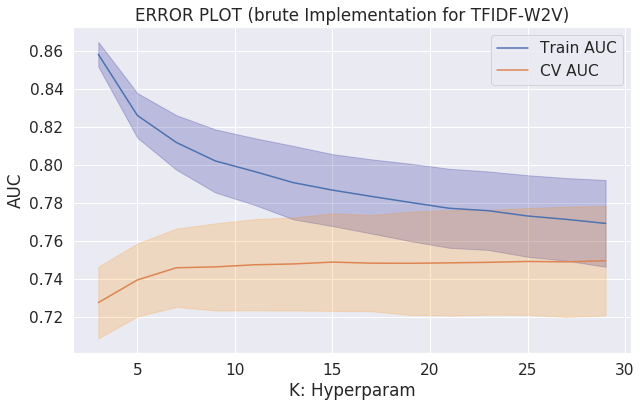

CPU times: user 1 s, sys: 1.12 s, total: 2.12 s
Wall time: 6min 39s
Optimal value of K:  {'n_neighbors': 29}


In [17]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=tfidf_sent_vectors,test=tfidf_sent_vectors_test,mean=True)
#OVERSAMPLE TRAIN DATA 
#train, y_train = oversampling(train, y_train)
#HYPERPARAM TUNNING
%time model=KNN_Classifier(train,y_train,TBS,k,searchMethod,algo[0],vect[3])
print('Optimal value of K: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfw2v_knn')

#### [1.2] Test Performance:

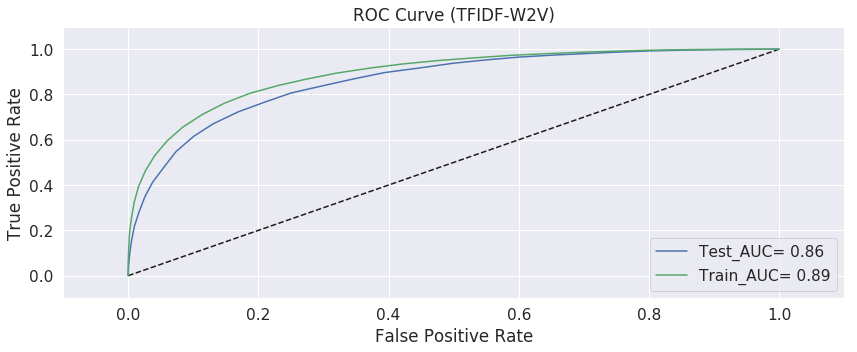

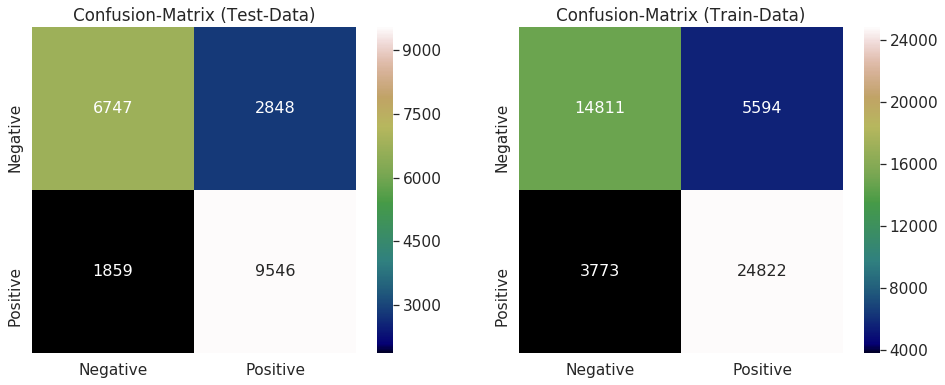

In [18]:
test_performance(train,y_train,test,y_test,model.best_params_['n_neighbors'],algo[0],vect[3],summarize)

#### 2. kd-tree implementation

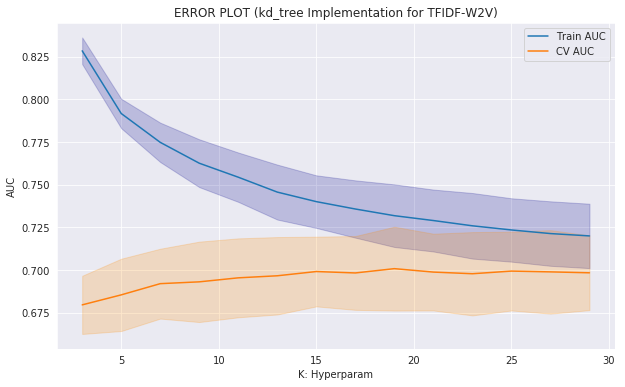

CPU times: user 1.3 s, sys: 1.69 s, total: 2.99 s
Wall time: 4min 33s
Optimal value of K:  {'n_neighbors': 19}


In [13]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=tfidf_sent_vectors_kd,test=tfidf_sent_vectors_test_kd,mean=True)
#HYPERPARAM TUNNING
%time model=KNN_Classifier(train,y_train_kd,TBS,k,searchMethod,algo[1],vect[3])
print('Optimal value of K: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfw2v_kd_knn')

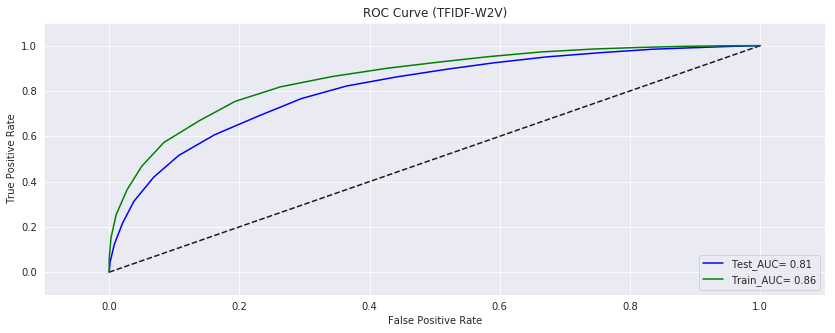

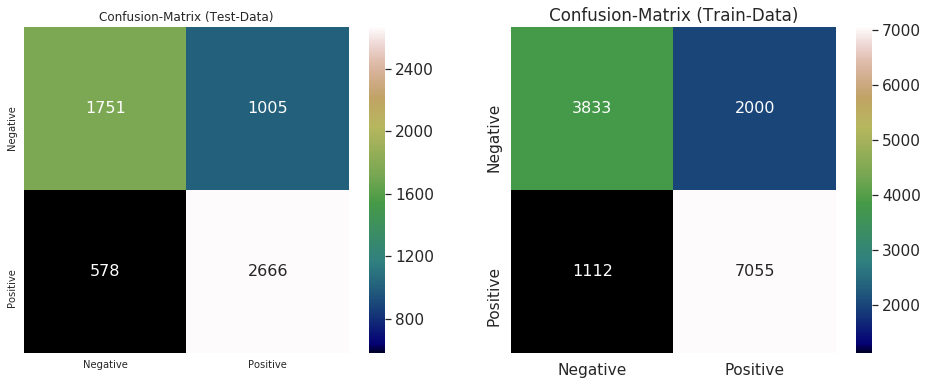

In [14]:
test_performance(train,y_train_kd,test,y_test_kd,model.best_params_['n_neighbors'],algo[1],vect[3],summarize)

# Conclusion:

In [40]:
print(summarize)

+------------+-----------+-----------+------------+-----------+
| Vectorizer | Algorithm | Optimal-K | Train(AUC) | Test(AUC) |
+------------+-----------+-----------+------------+-----------+
|    BoW     |   brute   |     3     |   89.48    |   60.44   |
|    BoW     |  kd_tree  |     3     |   91.44    |   70.75   |
|   TF-IDF   |   brute   |     3     |   99.01    |   51.64   |
|   TF-IDF   |  kd_tree  |     3     |   89.99    |   59.66   |
|  AVG-W2V   |   brute   |     23    |   91.93    |   89.35   |
|  AVG-W2V   |  kd_tree  |     15    |   89.62    |   84.20   |
| TFIDF-W2V  |   brute   |     29    |   89.20    |   86.20   |
| TFIDF-W2V  |  kd_tree  |     19    |   85.85    |   80.99   |
+------------+-----------+-----------+------------+-----------+


#### Got best performance with AVG-W2V:
        a. AUC = 89.35
        b. K = 23
        